In [1]:
# Import dependencies
import pandas as pd
from datetime import date
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

In [2]:
# Save lockdown data to dataframe
lockdown_link = 'data/covid_lockdown.csv'
lockdown_data = pd.read_csv(lockdown_link)
lockdown_data.tail()

,Countries and territories,Place,Start date,End date,Level
115,United States,New York,3/20/2020,5/15/2020,State
116,United States,Oregon,3/24/2020,NaN,State
117,United States,Wisconsin,3/24/2020,NaN,State
118,Venezuela,NaN,3/17/2020,5/13/2020,National
119,Zimbabwe,NaN,3/30/2020,5/2/2020,National


In [3]:
# To make calculations easier, replace any TBD or NaN in 'End date' with today's date.
today = str(date.today())

lockdown_data['End date'] = lockdown_data['End date'].fillna(today)
lockdown_data['End date'] = lockdown_data['End date'].str.replace(pat = 'TBD', repl= today)

In [4]:
# Apply median incubation period (5 days) to lockdown start date in order to see effectiveness of lockdown
incubation_period = timedelta(days=5)
lockdown_data['Lock Effect Start'] = pd.to_datetime(lockdown_data['Start date']) + incubation_period
lockdown_data['Lock Effect End'] = pd.to_datetime(lockdown_data['End date']) + incubation_period
lockdown_data.tail()

,Countries and territories,Place,Start date,End date,Level,Lock Effect Start,Lock Effect End
115,United States,New York,3/20/2020,5/15/2020,State,2020-03-25,2020-05-20
116,United States,Oregon,3/24/2020,2020-05-19,State,2020-03-29,2020-05-24
117,United States,Wisconsin,3/24/2020,2020-05-19,State,2020-03-29,2020-05-24
118,Venezuela,NaN,3/17/2020,5/13/2020,National,2020-03-22,2020-05-18
119,Zimbabwe,NaN,3/30/2020,5/2/2020,National,2020-04-04,2020-05-07


In [5]:
# For countries that have more than one 'place', only keep the first entry
index = []
for country in range(1, len(lockdown_data['Countries and territories'])):
    if lockdown_data['Countries and territories'][country] == lockdown_data['Countries and territories'][country -1]:
        index.append(country)
lock_data = lockdown_data.drop(lockdown_data.index[index])
lock_data.head()

,Countries and territories,Place,Start date,End date,Level,Lock Effect Start,Lock Effect End
0,Albania,NaN,3/13/2020,2020-05-19,National,2020-03-18,2020-05-24
1,Algeria,Algiers,3/23/2020,4/19/2020,City,2020-03-28,2020-04-24
3,Argentina,NaN,3/19/2020,5/10/2020,National,2020-03-24,2020-05-15
4,Armenia,NaN,3/24/2020,4/14/2020,National,2020-03-29,2020-04-19
5,Australia,NaN,3/23/2020,2020-05-19,National,2020-03-28,2020-05-24


In [6]:
# Make array of each country that experienced lockdown
lock_countries = lock_data['Countries and territories'].unique()
lock_countries

array(['Albania', 'Algeria', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bangladesh', 'Barbados', 'Belgium',
       'Bermuda', 'Bolivia', 'Botswana', 'Brazil', 'Chile', 'Colombia',
       'Republic of the Congo', 'Costa Rica', 'Croatia', 'Cuba',
       'Czech Republic', 'Denmark', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'Eritrea', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Guernsey', 'Honduras', 'Hungary',
       'India', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Jordan',
       'Kosova', 'Kuwait', 'Lebanon', 'Liberia', 'Libya', 'Lithuania',
       'Luxembourg', 'Madagascar', 'Malaysia', 'Mongolia', 'Montenegro',
       'Morocco', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand',
       'Nigeria', 'Northern Cyprus', 'Norway', 'Oman', 'Pakistan',
       'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines',
       'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Rwanda',
       'Samoa', 'Sa

In [7]:
# Pseudorandom sub_list from above countries: similar economic development in most
test_list = ['Australia', 'Austria', 'Finland', 'Germany', 'Ireland', 'Italy', 'Netherlands', 'Norway', 'Spain', 'Switzerland']
test_limit = timedelta(days=7)     # upper time period to observe for each country
Test_limit = timedelta(days=8)     # lower time period to observe for each country

In [8]:
# Save Worldwide Covid data to dataframe
cov_link = 'data/world_covid.csv'
cov_data = pd.read_csv(cov_link)
cov_data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,04/05/2020,4,5,2020,235,13,Afghanistan,AF,AFG,37172386.0,Asia
1,03/05/2020,3,5,2020,134,4,Afghanistan,AF,AFG,37172386.0,Asia
2,02/05/2020,2,5,2020,164,4,Afghanistan,AF,AFG,37172386.0,Asia
3,01/05/2020,1,5,2020,222,4,Afghanistan,AF,AFG,37172386.0,Asia
4,30/04/2020,30,4,2020,122,0,Afghanistan,AF,AFG,37172386.0,Asia


In [9]:
# Make array of all countries and territories
all_countries = cov_data['countriesAndTerritories'].unique()
len(all_countries)

209

In [10]:
# Left merge dataframes keeping the world covid data in tact
left_merge = cov_data.merge(lock_data, how='left', left_on='countriesAndTerritories', right_on='Countries and territories')

In [11]:
# Drop unneeded columns
left_merge = left_merge[['countriesAndTerritories', 'dateRep', 'cases', 'deaths', 'popData2018', 'Lock Effect Start', 'Lock Effect End']]

# Create boolean lockdown column and set to false when 'lockdown effective' is NaN
left_merge['Lockdown'] = pd.notnull(left_merge['Lock Effect Start'])

# Sets datatype of dates to datetime
left_merge['dateRep'] = pd.to_datetime(left_merge['dateRep'], infer_datetime_format=True)
left_merge['Lock Effect End'] = pd.to_datetime(left_merge['Lock Effect End'], infer_datetime_format=True)


In [12]:
# Loop and conditional to replace boolean lockdown values if the lockdown date falls outside the lockdown effective period
for date in range(len(left_merge['dateRep'])):
    if (left_merge['Lockdown'][date] == True) & ((left_merge['dateRep'][date] < left_merge['Lock Effect Start'][date]) | (left_merge['dateRep'][date] > left_merge['Lock Effect End'][date])):
        left_merge.at[date, 'Lockdown'] = False
left_merge.tail(50)


# After looking at the data closer, it seems there is a data entry problem in the source code.
# At one point it looks like they switched the day and month values in the dateRep column by mistake.

,countriesAndTerritories,dateRep,cases,deaths,popData2018,Lock Effect Start,Lock Effect End,Lockdown
14816,Zambia,2020-03-23,1,0,17351822.0,NaT,NaT,False
14817,Zambia,2020-03-22,0,0,17351822.0,NaT,NaT,False
14818,Zambia,2020-03-21,0,0,17351822.0,NaT,NaT,False
14819,Zambia,2020-03-20,0,0,17351822.0,NaT,NaT,False
14820,Zambia,2020-03-19,2,0,17351822.0,NaT,NaT,False
14821,Zimbabwe,2020-04-05,0,0,14439018.0,2020-04-04,2020-05-07,True
14822,Zimbabwe,2020-03-05,0,0,14439018.0,2020-04-04,2020-05-07,False
14823,Zimbabwe,2020-02-05,0,0,14439018.0,2020-04-04,2020-05-07,False
14824,Zimbabwe,2020-01-05,0,0,14439018.0,2020-04-04,2020-05-07,False
14825,Zimbabwe,2020-04-30,2,0,14439018.0,2020-04-04,2020-05-07,True


In [13]:
test_data = left_merge[left_merge['countriesAndTerritories'].isin(test_list)]    # make dataframe of only countries of interest
test_data['Pre-Lock'] = test_data['Lock Effect Start'] - Test_limit              # time period just before lockdown takes effect
test_data['Post-Lock'] = test_data['Lock Effect Start'] + test_limit             # time period just after lockdown takes effect


# Limit date range to only the test period
test_data.reset_index(drop=True, inplace=True)
for x in range(len(test_data)):
    if (test_data['dateRep'][x] <= test_data['Pre-Lock'][x]) | (test_data['dateRep'][x] >= test_data['Post-Lock'][x]):
        test_data.drop(labels= x, axis = 0, inplace= True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [14]:
# This loop adds the value 'date count' to compare date ranges of each country against each other
count = 1
test_data['Date Count'] = count
test_data.sort_values(by=['countriesAndTerritories', 'dateRep'], inplace=True)
test_data.reset_index(drop=True, inplace=True)
for index in range(1, len(test_data)):
    if (test_data['countriesAndTerritories'][index] == test_data['countriesAndTerritories'][index -1]) & (test_data['Lockdown'][index] == test_data['Lockdown'][index -1]):
        count += 1
        test_data['Date Count'][index] = count
    else:
        count = 1
        test_data['Date Count'][index] = count
test_data.head(15)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

,countriesAndTerritories,dateRep,cases,deaths,popData2018,Lock Effect Start,Lock Effect End,Lockdown,Pre-Lock,Post-Lock,Date Count
0,Australia,2020-03-21,165,1,24992369.0,2020-03-28,2020-05-24,False,2020-03-20,2020-04-04,1
1,Australia,2020-03-22,224,0,24992369.0,2020-03-28,2020-05-24,False,2020-03-20,2020-04-04,2
2,Australia,2020-03-23,611,0,24992369.0,2020-03-28,2020-05-24,False,2020-03-20,2020-04-04,3
3,Australia,2020-03-24,114,0,24992369.0,2020-03-28,2020-05-24,False,2020-03-20,2020-04-04,4
4,Australia,2020-03-25,600,1,24992369.0,2020-03-28,2020-05-24,False,2020-03-20,2020-04-04,5
5,Australia,2020-03-26,376,3,24992369.0,2020-03-28,2020-05-24,False,2020-03-20,2020-04-04,6
6,Australia,2020-03-27,367,2,24992369.0,2020-03-28,2020-05-24,False,2020-03-20,2020-04-04,7
7,Australia,2020-03-28,212,0,24992369.0,2020-03-28,2020-05-24,True,2020-03-20,2020-04-04,1
8,Australia,2020-03-29,431,1,24992369.0,2020-03-28,2020-05-24,True,2020-03-20,2020-04-04,2
9,Australia,2020-03-30,284,2,24992369.0,2020-03-28,2020-05-24,True,2020-03-20,2020-04-04,3


In [15]:
group_sum = test_data.groupby(['countriesAndTerritories', 'Lockdown'])[['cases', 'deaths']].sum()
group_sum

cases  deaths
countriesAndTerritories Lockdown               
Australia               False      2457       7
                        True       1399       6
Austria                 False      1835       5
                        True       4833      46
Finland                 False       613      12
                        True        173      11
Germany                 False     28150     210
                        True      19666     330
Ireland                 False       126       1
                        True        737       2
Italy                   False      2651     189
                        True      25922    2391
Netherlands             False      1846      71
                        True       4971     358
Norway                  False       588       1
                        True       1055       6
Spain                   False      9038     444
                        True      28495    2205
Switzerland             False      3719      36
                        True       7264     154

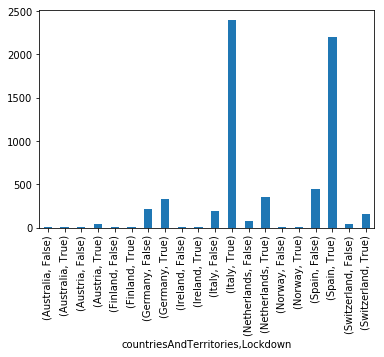

In [16]:
group_sum['deaths'].plot.bar()

# Because of the exponential spread of the virus, it is difficult to tease out the trend of whether the lockdowns were effective
# looking only at the raw sum, even over a very similar period of time.

In [17]:
group_mean = test_data.groupby(['countriesAndTerritories', 'Lockdown']).mean()
group_mean

cases      deaths  popData2018  \
countriesAndTerritories Lockdown                                         
Australia               False      351.000000    1.000000   24992369.0   
                        True       199.857143    0.857143   24992369.0   
Austria                 False      262.142857    0.714286    8847037.0   
                        True       690.428571    6.571429    8847037.0   
Finland                 False       87.571429    1.714286    5518050.0   
                        True        34.600000    2.200000    5518050.0   
Germany                 False     4021.428571   30.000000   82927922.0   
                        True      2809.428571   47.142857   82927922.0   
Ireland                 False       31.500000    0.250000    4853506.0   
                        True       105.285714    0.285714    4853506.0   
Italy                   False     2651.000000  189.000000   60431283.0   
                        True      3703.142857  341.571429   60431283.0   
Netherlands             False      263.714286   10.142857   17231017.0   
                        True       710.142857   51.142857   17231017.0   
Norway                  False      147.000000    0.250000    5314336.0   
                        True       150.714286    0.857143    5314336.0   
Spain                   False     1506.333333   74.000000   46723749.0   
                        True      4070.714286  315.000000   46723749.0   
Switzerland             False      531.285714    5.142857    8516543.0   
                        True      1037.714286   22.000000    8516543.0   

                                  Date Count  
countriesAndTerritories Lockdown              
Australia               False            4.0  
                        True             4.0  
Austria                 False            4.0  
                        True             4.0  
Finland                 False            4.0  
                        True             3.0  
Germany                 False            4.0  
                        True             4.0  
Ireland                 False            2.5  
                        True             4.0  
Italy                   False            1.0  
                        True             4.0  
Netherlands             False            4.0  
                        True             4.0  
Norway                  False            2.5  
                        True             4.0  
Spain                   False            3.5  
                        True             4.0  
Switzerland             False            4.0  
                        True             4.0

In [18]:
test_data[['cases', 'deaths']].describe()

,cases,deaths
count,125.000000,125.000000
mean,1164.304000,51.880000
std,1613.458279,111.369524
min,0.000000,0.000000
25%,126.000000,0.000000
50%,376.000000,3.000000
75%,1237.000000,34.000000
max,6584.000000,514.000000


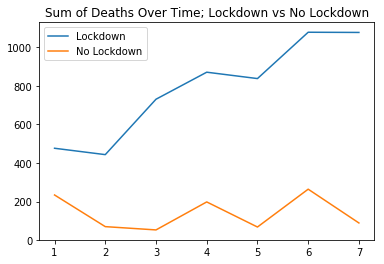

In [19]:
plt.plot(test_data[test_data['Lockdown'] == True].groupby(['Date Count'])['deaths'].sum(), label='Lockdown')
plt.plot(test_data[test_data['Lockdown'] == False].groupby(['Date Count'])['deaths'].sum(), label='No Lockdown')
plt.title('Sum of Deaths Over Time; Lockdown vs No Lockdown')
plt.legend()
plt.show()

# From this sample set of data, it is hard to see if locking down stifled the infection rate over similar periods of time.
# Even if the death rate was slowed, going under lockdown apparently did not stifle the infection rate enough to actually
# cause a decrease in rates of death during this time period. The time period before lockdown seems more stable on average,
# which could be the result of early exponential datasets seeing relatively miniscule changes at the begining

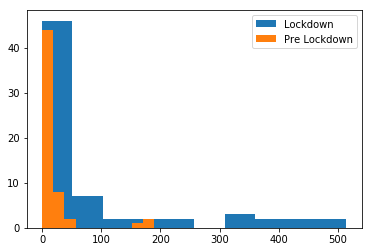

In [20]:
plt.hist(test_data[test_data['Lockdown'] == True]['deaths'], label='Lockdown')
plt.hist(test_data[test_data['Lockdown'] == False]['deaths'], label='Pre Lockdown')
plt.legend()
plt.show()

# Data is non-normally distributed, so a normal ttest cant be used

In [21]:
# Wilcoxon test used because the data is non-normally distributed and all datasets experienced both A/B version of the test
# (in this case it is whether going into lockdown had an effect on rates of death)
stats.wilcoxon((test_data[test_data['Lockdown'] == True]['deaths']-test_data[test_data['Lockdown'] == False]['deaths']))

# The pvalue is incredibly low which means we can reject the hypothesis of the differences in medians being due to random chance
# and that the population has a median distinct from the hypothetical value selected

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2781: RuntimeWarning: invalid value encountered in greater
  r_plus = np.sum((d > 0) * r, axis=0)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:2782: RuntimeWarning: invalid value encountered in less
  r_minus = np.sum((d < 0) * r, axis=0)


WilcoxonResult(statistic=0.0, pvalue=2.9643799464905646e-22)

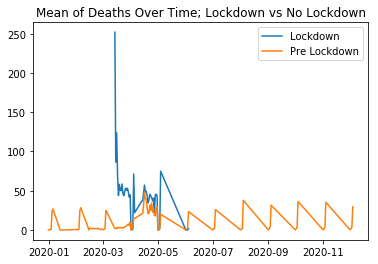

In [22]:
plt.plot(left_merge[left_merge['Lockdown'] == True].groupby(['dateRep'])['deaths'].mean(), label='Lockdown')
plt.plot(left_merge[left_merge['Lockdown'] == False].groupby(['dateRep'])['deaths'].mean(), label='Pre Lockdown')
plt.title('Mean of Deaths Over Time; Lockdown vs No Lockdown')
plt.legend()
plt.show()

# graph info isnt extremely meaningful since each country got infected at different points in time and went into lockdown
# at different points in time, but the curious pattern and date range hints at a data entry error.
# Closer inspection suggests all the countries are having the same date entry problem where the month and day values are
# switched, causing a lot of the data to be grouped in regular intervals at the end of the graph.

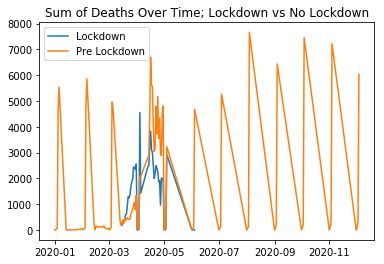

In [23]:
# Plotting worldwide group data
plt.plot(left_merge[left_merge['Lockdown'] == True].groupby(['dateRep'])['deaths'].sum(), label='Lockdown')
plt.plot(left_merge[left_merge['Lockdown'] == False].groupby(['dateRep'])['deaths'].sum(), label='Pre Lockdown')
plt.title('Sum of Deaths Over Time; Lockdown vs No Lockdown')
plt.legend()
plt.show()

# Another graph showing the odd trend in spikes, as before, which further indicates there was probably an error in data entry.

In [24]:
mean_deaths = test_data['deaths'].mean()
mean_cases = test_data['cases'].mean()
mean_pop = test_data['popData2018'].mean()
death_per_case = mean_deaths / mean_cases
cases_per_pop = mean_cases / mean_pop
print('Mean deaths per mean positive cases: {}'.format(death_per_case))
print('Mean positve cases per average population: {}'.format(cases_per_pop))

Mean deaths per mean positive cases: 0.04455880938311644
Mean positve cases per average population: 4.458706817645587e-05


In [25]:
# To summarize:
# Even if there was a slowdown in number of deaths per day, there wasn't enough to cause the rate of deaths to decrease
# over time. This means lockdowns alone aren't enough to stem the eponential nature of the virus spread. To see the actual
# effectiveness of the lockdowns, further tests can be compared to those countries just upon re-opening. If given more time,
# different date ranges could be compared or the countries could be compared individually to see if the results are similar
# enough to verify the trends seen already. If the data is further cleaned, the date ranges being compared could be extended
# without worrying about using the corrupt bits of data entry instead of focusing just on the week before and after the
# effects of the lockdown are noticeable.